In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import sys
sys.modules['Image'] = Image 
import pandas as pd
import numpy as np
import cv2
import os

2025-04-18 20:52:00.233110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745023921.116339   80656 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745023921.354601   80656 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745023923.622629   80656 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745023923.622656   80656 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745023923.622658   80656 computation_placer.cc:177] computation placer alr

In [3]:
# Globals   
path_to_data_dir = "../../database/sorted_by_state/"
test_file = "Arkansas/_09TL3yHwqMzcB8m4BUGoQ.jpeg"

In [4]:
BATCH_SIZE = 16


train_dataset = tf.keras.utils.image_dataset_from_directory(
    path_to_data_dir,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(224, 224),
    validation_split=0.2,
    subset='training',
    seed=42,
    shuffle=True
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    path_to_data_dir,
    labels='inferred',
    label_mode='int', 
    batch_size=BATCH_SIZE,
    image_size=(224, 224),
    validation_split=0.2,
    subset='validation',
    seed=42,
    shuffle=False
)

Found 49376 files belonging to 51 classes.
Using 39501 files for training.


2025-04-18 20:52:19.933471: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Found 49376 files belonging to 51 classes.
Using 9875 files for validation.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(ds):
    return ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y), num_parallel_calls=AUTOTUNE)

train_dataset = preprocess(train_dataset).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = preprocess(validation_dataset).cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
# model with 3 convolution layers max pooled 3 times with relu as activation function and softmax applied to output layer
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', use_bias=True),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', use_bias=True),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(51, activation='softmax')
])


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=RMSprop(learning_rate=0.001),
              metrics=[
                'accuracy',
                tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)
              #tf.keras.metrics.
              #tf.keras.metrics.Precision(),
              #tf.keras.metrics.F1Score(),
            ],
          )

/home/holdw/school/cse404/CSE404-Group-Project/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
#from tensorflow.keras.callbacks import Callback

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=1,  
    callbacks=[early_stopping]
)

#model.save('state_classifier.keras')

  77/2469 ━━━━━━━━━━━━━━━━━━━━ 12:31 314ms/step - accuracy: 0.0291 - loss: 157.5806 - sparse_top_k_categorical_accuracy: 0.1697

KeyboardInterrupt: 

In [ ]:
class_names = sorted(os.listdir(path_to_data_dir))

def predict_state(image_path):
    img = Image.open(image_path).resize((224, 224))  # Match training size
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch dimension
    img_array = img_array / 255.0  # Normalize like training data

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    
    # Get top 3 predictions
    top_3 = np.argsort(predictions[0])[-3:][::-1]
    
    print(f"\nPredicted State: {class_names[predicted_class]} ({(confidence*100):.2f}% confidence)")
    print("\nTop 3 Predictions:")
    for i, idx in enumerate(top_3):
        print(f"{i+1}. {class_names[idx]} ({(predictions[0][idx]*100):.2f}%)")
    
    return class_names[predicted_class]

In [ ]:
state = predict_state('../../database/stoddard (1).jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step

Predicted State: Georgia (56.94% confidence)

Top 3 Predictions:
1. Georgia (56.94%)
2. Arkansas (28.61%)
3. Connecticut (13.69%)


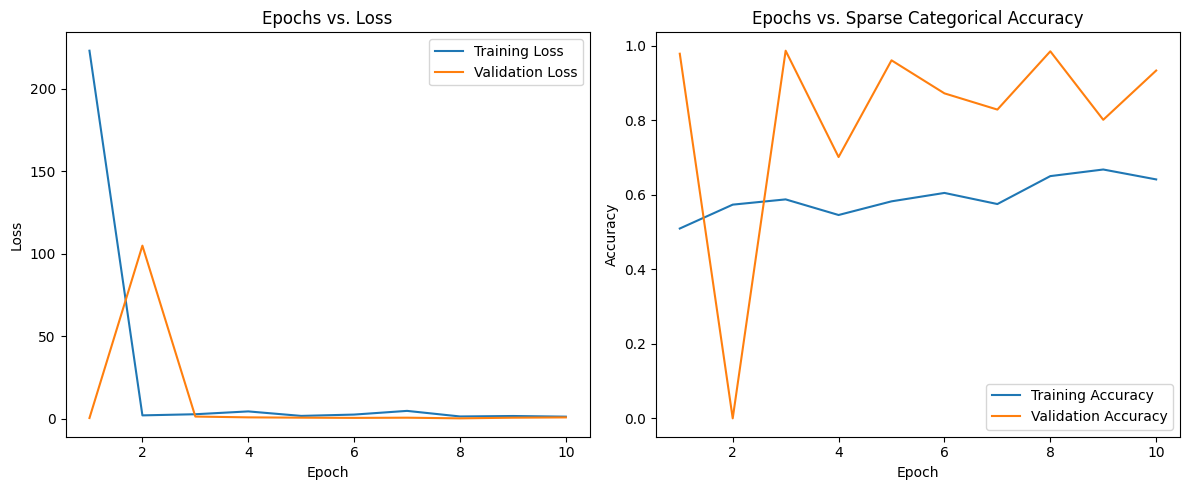

In [ ]:
#epochs_to_save = [1,2]

# model_version= "v1.0"

# save_dir = "saved_models/"

# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# class CustomCallback(Callback):
#     def __init__(self, epochs_to_save):
#         super().__init__()
#         self.epochs_to_save = epochs_to_save
 
#     def on_epoch_end(self, epoch, logs=None):
#         if epoch in self.epochs_to_save:
#             fn = f'{model_version}_{epoch:02d}.keras'

#             # Save the model weights
#             self.model.save(save_dir + fn)
#             print(f"Model weights saved at epoch {epoch} to {fn}")


# custom_callback = CustomCallback(epochs_to_save=epochs_to_save)



# for epoch in epochs_to_save:
#     fn = f'{model_version}_{epoch:02d}.keras'
#     model.load_weights(save_dir + fn)

#     # Evaluate the model on the validation dataset
#     loss, accuracy, recall, precision, f1_score = model.evaluate(validation_dataset)
#     print(f"Model {fn} - Loss: {loss}, Validation Accuracy: {accuracy}, Validation Precision: {precision}, Validation Recall: {recall}, Validation f1_score: {f1_score}")

history = model_fit.history

epochs = range(1, len(history['loss']) + 1)

save_dir = os.path.abspath("graphs")
os.makedirs(save_dir, exist_ok=True)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epochs vs. Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(epochs, history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epochs vs. Sparse Categorical Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Save the figure
save_path = os.path.join(save_dir, "training_curves.png")
plt.tight_layout()
plt.savefig(save_path)
plt.close()


